# **Proyecto Generación de música automática**

![picture](https://www.smartpiano.com.au/wp-content/uploads/2017/11/Fotolia_83643105_Subscription_Monthly_M.jpg)

El presente proyecto se trata de la creación automática de pequeños fragmentos musicales usando diferentes párameteros como intervalos, acordes, ritmos, tempo, entre otros, a partir de obras para piano de compositores  principalmente del clasicismo y del romanticismo en formato MIDI que se encuentran disponibles en Kaggle en el siguiente enlace: https://www.kaggle.com/soumikrakshit/classical-music-midi

## **0. Objetivos**



*   Implementar un modelo que permita la generación de fragmentos musicales para piano a partir de ciertos parámetros introducidos por el usuario.
*   Utilizar una red neuronal LSTM como modelo de Deep Learning





## **1. Dataset**

Descargamos el dataset que se encuentra en Google Drive

In [1]:
!gdown 1L-4v6oKVdPqMsgNF84ns7xlMSY2-2Eyn

Downloading...
From: https://drive.google.com/uc?id=1L-4v6oKVdPqMsgNF84ns7xlMSY2-2Eyn
To: /content/Music_generation.zip
100% 2.45M/2.45M [00:00<00:00, 231MB/s]


Los audios en formato MIDI se encuentran comprimidos en zip y los incluimos en la carpeta 'music':

In [2]:
!mkdir music

In [ ]:
!unzip "/content/Music_generation.zip" -d 'music'

Tenemos en total 295 archivos MIDI:

In [ ]:
import os
count = 0
for root_dir, cur_dir, files in os.walk('music'):
    count += len(files)
print('file count:', count)

Veámos la estructura de los datos en la carpeta 'music'

In [ ]:
!apt install tree

In [ ]:
!tree music

# **2. Exploración y Preprocesamiento de los datos**

Para este proyecto vamos a ser uso extensivo de la librería music21, la cual permite analizar los archivos MIDI y extraer las notas (entendidas como frecuencias o alturas y sus duraciones) y acordes (notas que suenan simultáneamente) del archivo.

In [7]:
from music21 import *
import glob
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

Lectura y análisis de los archivos MIDI

In [8]:
def extract_notes(file):
  notes=[]
  pick=None
  #convertimos el archivo midi
  midi=converter.parse(file)
  #separamos los instrumentos del archivo
  instrmt=instrument.partitionByInstrument(midi)

  for part in instrmt.parts:
    #separamos los datos solamente para piano
    if 'Piano' in str(part):
      pick=part.recurse()

      #se itera sobre los elementos
      #Se verifica si el elemento es nota o acorde, en caso de este último se separa en notas

      for element in pick:
        if type(element)==note.Note:
          notes.append(str(element.pitch))
        elif type(element)==chord.Chord:
          notes.append('.'.join(str(n) for n in element.normalOrder))

  #retornamos una lista de las notas
  return notes

Por simplicidad vamos a utilizar solamente los archivos MIDI del compositor noruego Edvard Grieg:

In [9]:
file_path=["music/grieg"]
all_files=glob.glob(file_path[0]+'/*.mid',recursive=True)
#conformamos el corpus con los archivos MIDI preprocesados
corpus = np.array([extract_notes(i) for i in all_files], dtype=object)

/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'W\xe4chterlied Op12, No. 3'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1997 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1998 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_

Revisemos cuántas notas únicas se tienen y cuál es su distribución:

Unique Notes: 248
30 : 116
50 : 89
70 : 64
90 : 51
110 : 44
130 : 33
150 : 29
170 : 23
190 : 16


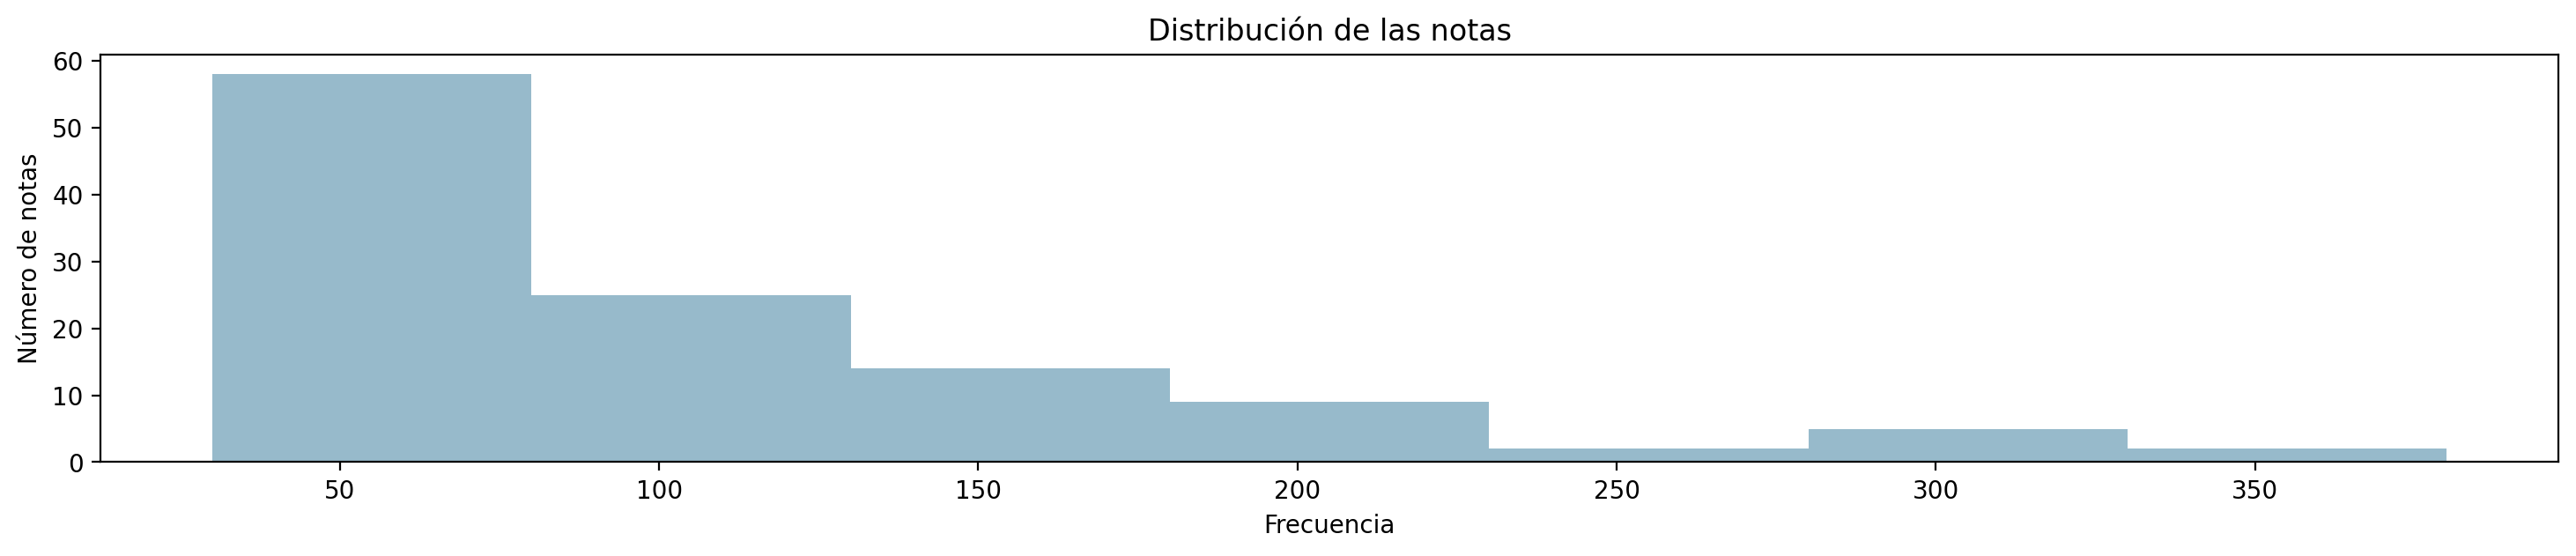

In [10]:
#notas únicas
notess = sum(corpus,[])
unique_notes = list(set(notess))
print("Unique Notes:",len(unique_notes))
#notas con su frecuencia
freq=dict(map(lambda x: (x,notess.count(x)),unique_notes))
recurrence = list(freq.values())
for i in range(30,200,20):
  print(i,":",len(list(filter(lambda x:x[1]>=i,freq.items()))))
#gráfica
plt.figure(figsize=(18,3))
bins = np.arange(30,max(recurrence), 50)
plt.hist(recurrence, bins=bins, color="#97BACB")
plt.title("Distribución de las notas")
plt.xlabel("Frecuencia")
plt.ylabel("Número de notas")
plt.show()


Seleccionamos un umbral para la frecuencia de las notas para remover sonidos de baja frecuencia y facilitar la generación de la música

In [11]:
umbral = 50
freq_notes=dict(filter(lambda x:x[1]>=umbral,freq.items()))
#creamos nuevas notas usando la frecuencia
new_notes=[[i for i in j if i in freq_notes] for j in corpus]

Creamos diccionarios con los índices de las notas como keys y notas como values y viceversa:

In [12]:
#diccionario con el índice de nota como key y la nota como value
ind2note=dict(enumerate(freq_notes))
#diccionario con la nota como key y el índice de nota como value
note2ind=dict(map(reversed,ind2note.items()))
print(ind2note.items())
print(len(ind2note))

dict_items([(0, '6.10'), (1, '7.11.2'), (2, '1.4'), (3, '2.6.9'), (4, '7.9'), (5, 'F#4'), (6, 'F4'), (7, '0'), (8, 'F3'), (9, '9.10'), (10, 'C#3'), (11, 'F#5'), (12, '5.9.0'), (13, '0.2'), (14, '6.11'), (15, '4.7'), (16, '7.10'), (17, 'C4'), (18, '6.10.1'), (19, '4.7.11'), (20, 'G#5'), (21, '11.3'), (22, 'E4'), (23, 'E-4'), (24, 'B1'), (25, 'A2'), (26, '9.1.4'), (27, '2.5'), (28, 'G#3'), (29, 'E3'), (30, 'A3'), (31, 'B-4'), (32, 'D4'), (33, '7.11'), (34, 'B-2'), (35, 'C#4'), (36, 'C#6'), (37, 'G#4'), (38, '0.4'), (39, 'C#5'), (40, 'B5'), (41, 'D2'), (42, 'D6'), (43, 'C5'), (44, 'B2'), (45, '11.2'), (46, 'E-2'), (47, 'F#3'), (48, '5.9'), (49, 'D3'), (50, 'G3'), (51, '0.6'), (52, 'E2'), (53, '10.2'), (54, '9.2'), (55, 'C3'), (56, 'E6'), (57, '7.0'), (58, 'D5'), (59, '8.11'), (60, 'B3'), (61, 'B-5'), (62, 'B-3'), (63, 'G4'), (64, 'G2'), (65, 'F5'), (66, '10.0'), (67, '6.9'), (68, '10.3'), (69, 'F#2'), (70, 'F6'), (71, '4.9'), (72, '2.7'), (73, 'B4'), (74, 'E5'), (75, '2.6'), (76, 'A4'), (

# **3. Datos de entrada y salida para el modelo**

In [13]:
length=50 #se divide el corpus en strings de igual longitud
x=[] ; y=[]
for i in new_notes:
 for j in range(0,len(i)-length):
  #Los datos de entrada serán el índice + longitud dada
  #Los datos de salida serán el siguiente índice después de la longitud dada
  inp=i[j:j+length] ; out=i[j+length]
  #Agregar el valor del índice de las notas respetivas
  x.append(list(map(lambda x:note2ind[x],inp)))
  y.append(note2ind[out])
x_new=np.array(x)
y_new=np.array(y)

In [14]:
print(x_new.shape, y_new.shape)

(10922, 50) (10922,)


## **3.1 Conjuntos de entrenamiento y evaluación**

In [15]:
x_new = np.reshape(x_new,(len(x_new),length,1))
y_new = np.reshape(y_new,(-1,1))
x_train,x_test,y_train,y_test = train_test_split(x_new,y_new,test_size=0.2,random_state=42)

# **4. Modelo**

Creamos un modelo de Deep Learning usando dos capas LSTM:

In [16]:
input = tf.keras.layers.Input((x_new.shape[1],x_new.shape[2]))
#capa LSTM con dimensión latente de 288
capa_LSTM = tf.keras.layers.LSTM(288,return_sequences=True)(input)
#dropout
dropout = tf.keras.layers.Dropout(0.1)(capa_LSTM)
#segunda capa LSTM con dimensión latente de 288
capa_LSTM = tf.keras.layers.LSTM(288)(dropout)
#segunda capa dropout
dropout = tf.keras.layers.Dropout(0.1)(capa_LSTM)
#capa densa con activación relu
dense = tf.keras.layers.Dense(288,activation='relu')(dropout)
#capa densa con activación softmax
output = tf.keras.layers.Dense(len(note2ind),activation='softmax')(dense)
model = tf.keras.models.Model(input, output)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 50, 288)           334080    
                                                                 
 dropout (Dropout)           (None, 50, 288)           0         
                                                                 
 lstm_1 (LSTM)               (None, 288)               664704    
                                                                 
 dropout_1 (Dropout)         (None, 288)               0         
                                                                 
 dense (Dense)               (None, 288)               83232     
                                                                 
 dense_1 (Dense)             (None, 89)                25721 

La estructura del modelo es la siguiente:

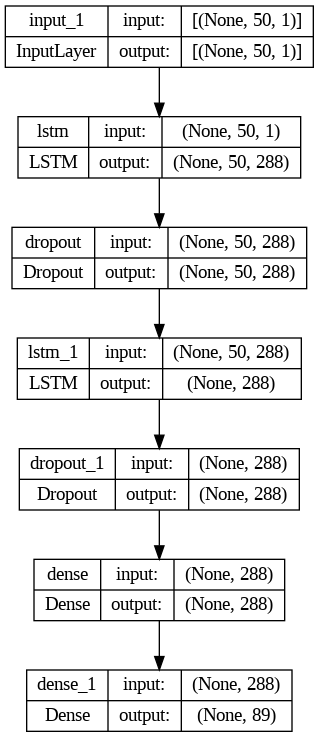

In [17]:
tf.keras.utils.plot_model(model,show_shapes=True)

## **4.1 Entrenamiento del modelo**

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
best_callback = tf.keras.callbacks.ModelCheckpoint(filepath="LSTM.h5",
                                                      monitor="val_loss",
                                                      verbose=True,
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      mode="min")
history = model.fit(
 x_train,y_train,
 batch_size=128,epochs=100,
 validation_data=(x_test,y_test))

Epoch 1/100
69/69 [==============================] - 12s 36ms/step - loss: 4.3535 - accuracy: 0.0302 - val_loss: 4.2840 - val_accuracy: 0.0426
Epoch 2/100
69/69 [==============================] - 1s 21ms/step - loss: 4.2632 - accuracy: 0.0391 - val_loss: 4.2479 - val_accuracy: 0.0430
Epoch 3/100
69/69 [==============================] - 1s 21ms/step - loss: 4.1975 - accuracy: 0.0431 - val_loss: 4.1802 - val_accuracy: 0.0577
Epoch 4/100
69/69 [==============================] - 1s 21ms/step - loss: 4.1131 - accuracy: 0.0538 - val_loss: 4.1156 - val_accuracy: 0.0535
Epoch 5/100
69/69 [==============================] - 1s 22ms/step - loss: 3.9867 - accuracy: 0.0721 - val_loss: 4.0371 - val_accuracy: 0.0783
Epoch 6/100
69/69 [==============================] - 2s 22ms/step - loss: 3.8695 - accuracy: 0.0958 - val_loss: 3.9071 - val_accuracy: 0.0906
Epoch 7/100
69/69 [==============================] - 2s 22ms/step - loss: 3.6820 - accuracy: 0.1293 - val_loss: 3.8041 - val_accuracy: 0.1295
Epoch

Veamos el comportamiento del entrenamiento:

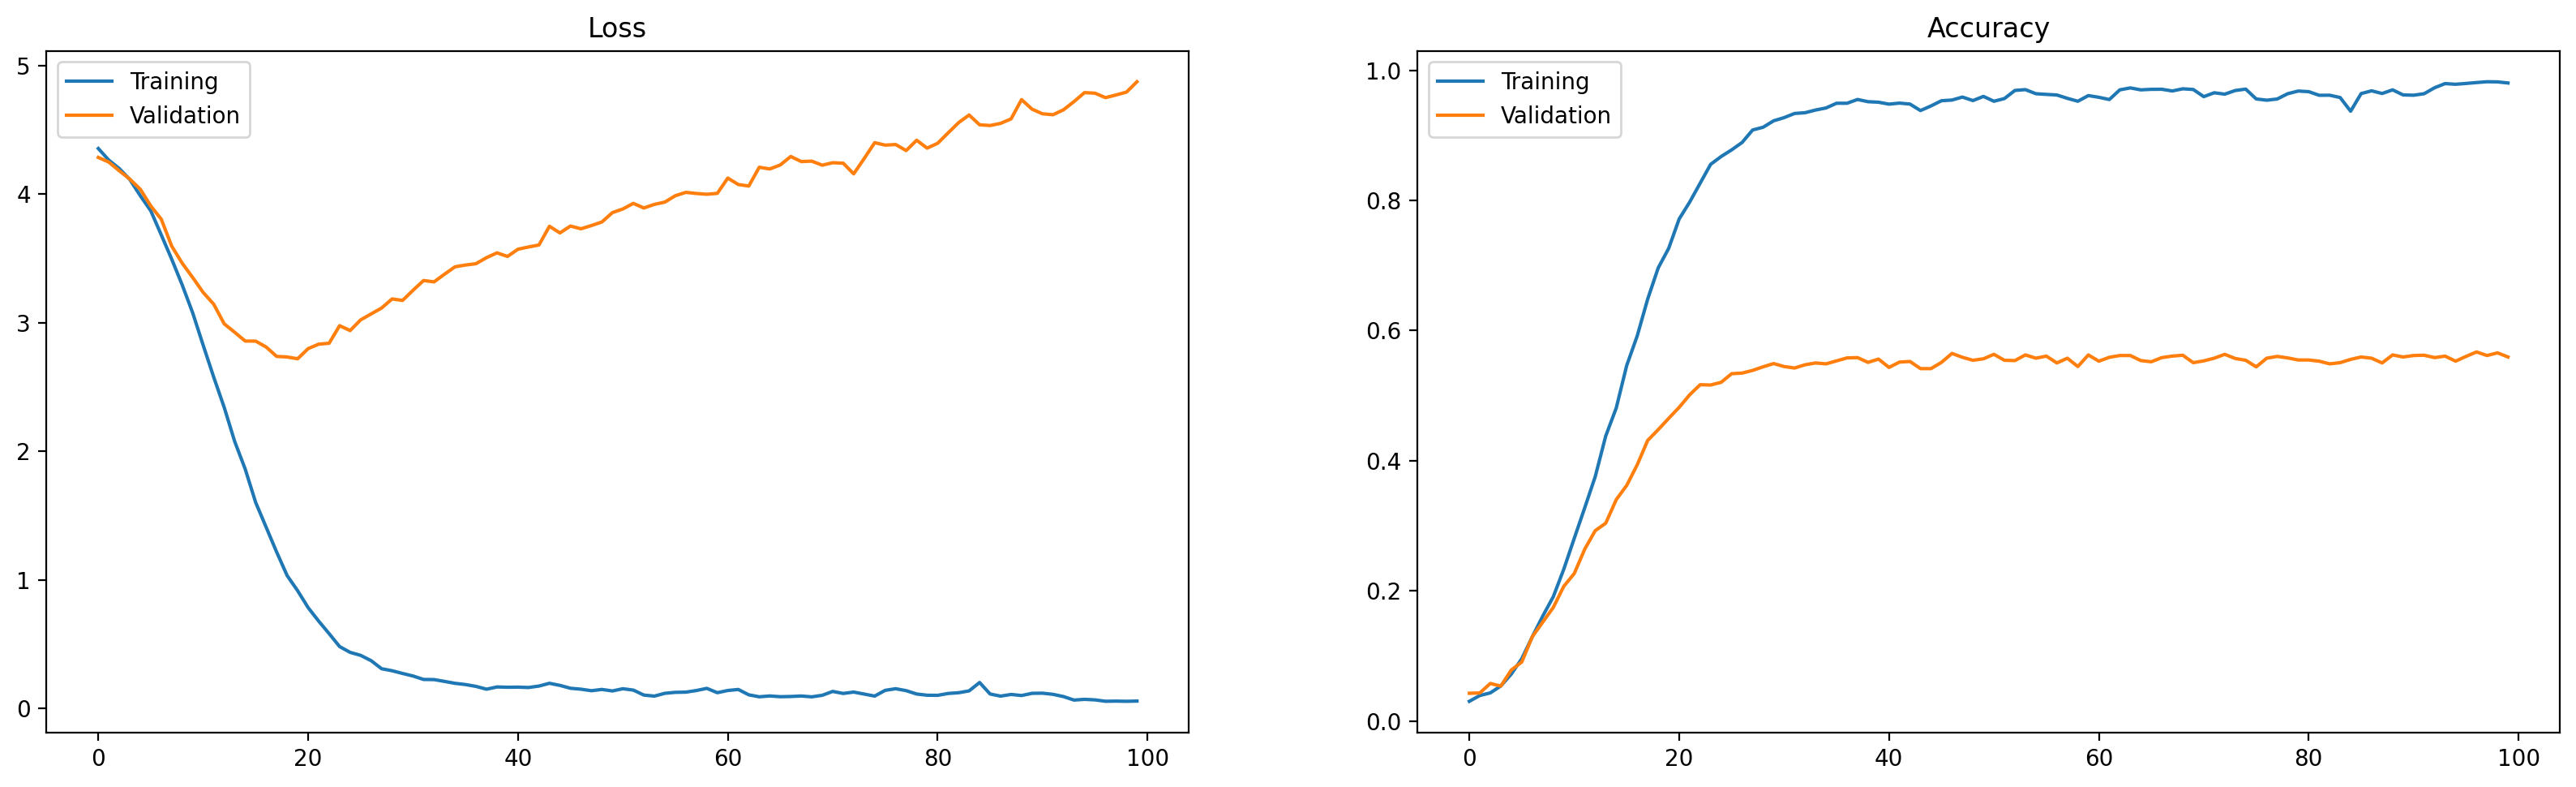

In [19]:
plt.figure(figsize=(20,12))

plt.subplot(2,2,1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.legend()

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.legend()

plt.show()

Guardamos el modelo:

In [ ]:
model.save("LSTM")

## **4.2 Búsqueda de hiperparámetros**

In [18]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.1 MB/s eta 0:00:00


In [19]:
import keras_tuner

Vamos a realizar una búsqueda para las unidades de las capas LSTM y la tasa de aprendizaje

In [20]:
def call_existing_code(units, lr):
  input = tf.keras.layers.Input((x_new.shape[1],x_new.shape[2]))

  capa_LSTM = tf.keras.layers.LSTM(units=units,return_sequences=True)(input)

  dropout = tf.keras.layers.Dropout(0.1)(capa_LSTM)

  capa_LSTM = tf.keras.layers.LSTM(units=units)(dropout)

  dropout = tf.keras.layers.Dropout(0.1)(capa_LSTM)

  dense = tf.keras.layers.Dense(units=units,activation='relu')(dropout)

  output = tf.keras.layers.Dense(len(note2ind),activation='softmax')(dense)
  model = tf.keras.models.Model(input, output)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  return model

def build_model(hp):
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    # Llamamos el modelo existente con los valores de los hiperparámetros
    model = call_existing_code(lr=lr, units=units)
    return model

Comenzamos la búsqueda

In [21]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="",
    project_name="music",
)

tuner.search_space_summary()

Search space summary
Default search space size: 2
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


In [22]:
tuner.search(x_train, y_train, epochs=10, validation_data=(x_test,y_test))

Trial 3 Complete [00h 01m 44s]
val_accuracy: 0.1723112091422081

Best val_accuracy So Far: 0.22013729810714722
Total elapsed time: 00h 04m 36s


Resultados de la búsqueda:

In [23]:
tuner.results_summary()

Results summary
Results in ./music
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
lr: 0.0027157256420724187
units: 288
Score: 0.22013729810714722

Trial 2 summary
Hyperparameters:
lr: 0.0027122255603887007
units: 416
Score: 0.1723112091422081

Trial 0 summary
Hyperparameters:
lr: 0.00891032967210355
units: 384
Score: 0.03752860426902771
